In [1]:
%matplotlib inline

In [2]:
import sys
import pickle
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from networkx.algorithms.approximation import clique
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from tqdm.notebook import tqdm

from helpers import SBM_Data, load_or_calc_and_save, ytrue_to_partition, calc_avranks, RFE, OneVsRest_custom

sys.path.append('../../pygkernels')
from pygkernels.scenario import d3_category20

In [3]:
data_hub = SBM_Data()

X, y = data_hub.make_dataset()
X_train, y_train = X[:, :70].reshape(-1, X.shape[2]), y[:, :70].reshape(-1, y.shape[2])
X_val,   y_val   = X[:, 70:].reshape(-1, X.shape[2]), y[:, 70:].reshape(-1, y.shape[2])
X,       y       = X.reshape(-1, X.shape[2]), y.reshape(-1, y.shape[2])

_, y_ari = data_hub.make_dataset(return_clf=False)
ari_train = y_ari[:, :70].reshape(-1, y_ari.shape[2])
ari_val = y_ari[:, 70:].reshape(-1, y_ari.shape[2])

feature_names = data_hub.allowed_features_list

prepare columns:  87%|████████▋ | 84/97 [00:00<00:00, 835.77it/s]

wrapper: RECALC ../../cache/cache/feature_importance/dataset2sbm_dolphins.pkl. args: , kwargs: 
Dataset dolphins not in cache; reload
wrapper: RECALC ../../cache/cache/feature_importance/dataset2sbm_football.pkl. args: , kwargs: 
Dataset football not in cache; reload


prepare columns:  96%|█████████▌| 93/97 [00:57<00:07,  1.90s/it] 

wrapper: RECALC ../../cache/cache/feature_importance/dataset2sbm_karate.pkl. args: , kwargs: 
Dataset karate not in cache; reload


prepare columns:  97%|█████████▋| 94/97 [00:59<00:06,  2.18s/it]

wrapper: RECALC ../../cache/cache/feature_importance/dataset2sbm_news_2cl1.pkl. args: , kwargs: 
Dataset news_2cl1 not in cache; reload


prepare columns:  98%|█████████▊| 95/97 [29:38<17:14, 517.14s/it]

wrapper: RECALC ../../cache/cache/feature_importance/dataset2sbm_news_2cl2.pkl. args: , kwargs: 
Dataset news_2cl2 not in cache; reload


prepare columns:  99%|█████████▉| 96/97 [1:00:09<15:11, 911.20s/it]

wrapper: RECALC ../../cache/cache/feature_importance/dataset2sbm_news_2cl3.pkl. args: , kwargs: 
Dataset news_2cl3 not in cache; reload


prepare columns: 100%|██████████| 97/97 [1:25:27<00:00, 52.86s/it]  
/home/illusionww/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
prepare columns: 100%|██████████| 97/97 [00:00<00:00, 719.50it/s]


# Feature importance

In [4]:
X.shape

(9700, 19)

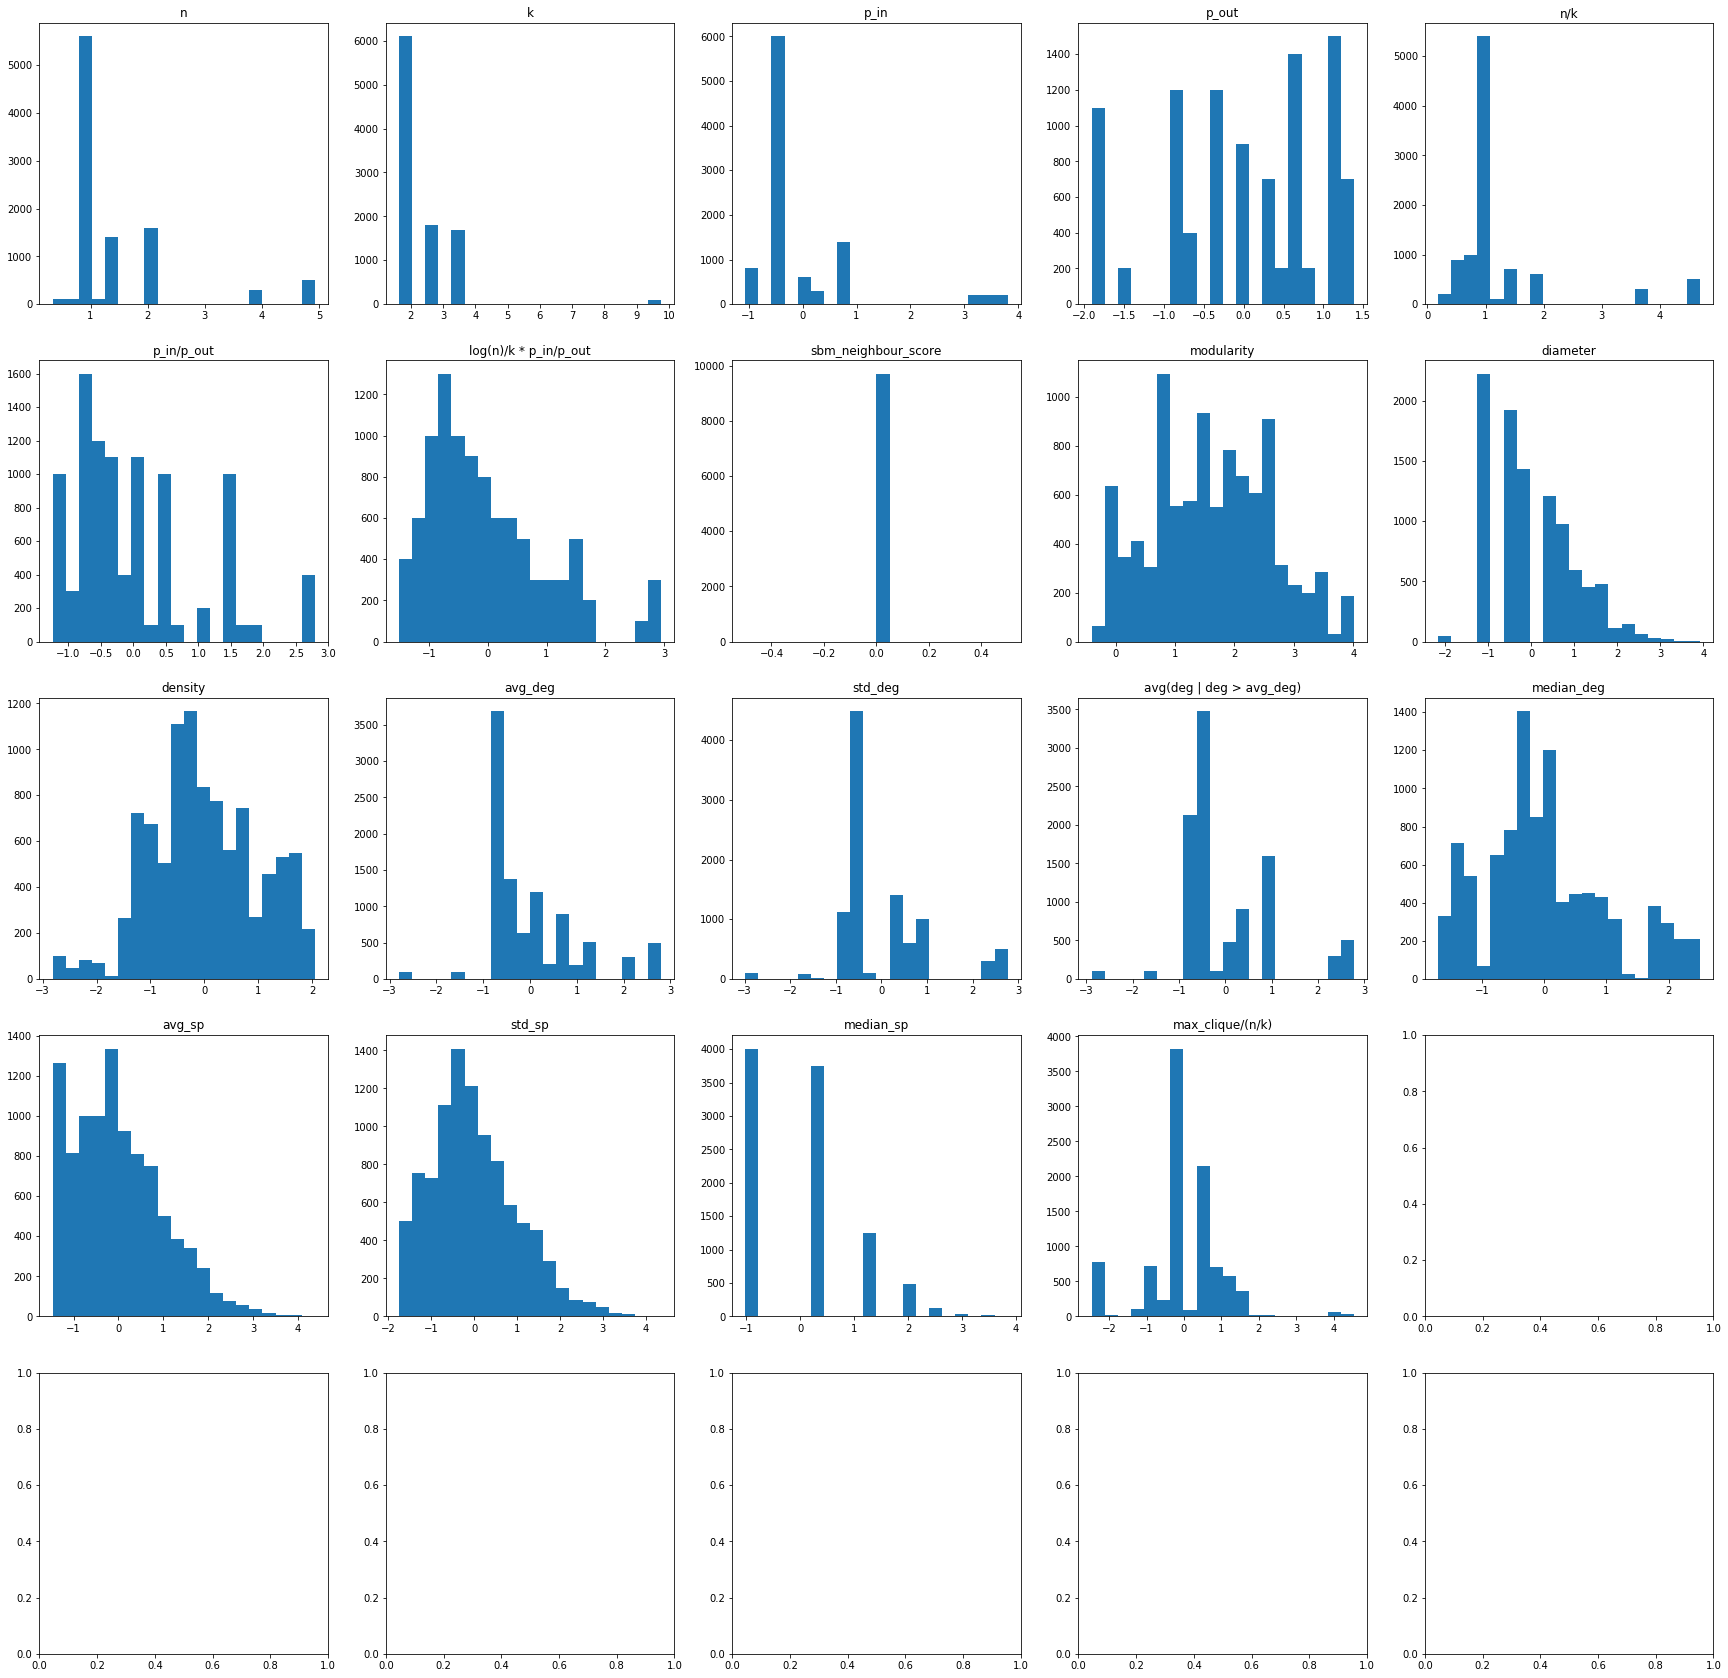

In [5]:
fig, ax = plt.subplots(5, 5, figsize=(30, 30))
ax = ax.ravel()
for i, name in enumerate(data_hub.allowed_features_list):
    ax[i].hist(X[:, i], bins=20)
    ax[i].set_title(name)

# Remove useless measures

24/25: most useless=Katz, best in 10/6790, max quality wo this measure 0.7439
23/25: most useless=DF, best in 17/6790, max quality wo this measure 0.7438
22/25: most useless=Abs, best in 29/6790, max quality wo this measure 0.7436
21/25: most useless=logAbs, best in 31/6790, max quality wo this measure 0.7435
20/25: most useless=logNHeat, best in 37/6790, max quality wo this measure 0.7434
19/25: most useless=logPPR, best in 40/6790, max quality wo this measure 0.7433
18/25: most useless=logDF, best in 50/6790, max quality wo this measure 0.7432
17/25: most useless=PPR, best in 52/6790, max quality wo this measure 0.7428
16/25: most useless=FE, best in 70/6790, max quality wo this measure 0.7426
15/25: most useless=HeatPR, best in 72/6790, max quality wo this measure 0.7423
14/25: most useless=Comm, best in 89/6790, max quality wo this measure 0.7419
13/25: most useless=logKatz, best in 96/6790, max quality wo this measure 0.7416
12/25: most useless=SP-CT, best in 119/6790, max quality

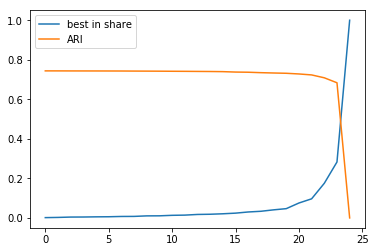

In [6]:
plot_useless = []
support_kernels = np.array([True] * 25)
while np.sum(support_kernels) > 0:
    ari_subset = ari_train[:, support_kernels]
    kernel_names_subset = np.array(data_hub.kernel_names)[support_kernels]
    most_useless = ('none', ari_subset.shape[0] + 1)
    for idx, kernel_name in enumerate(kernel_names_subset):
        a = np.array([True] * np.sum(support_kernels))
        a[idx] = False
        y_measure = ari_subset[:, idx]
        y_rest = np.max(ari_subset[:, a], axis=1) if np.sum(a) > 0 else -1
        stat = Counter(y_measure > (y_rest + 0.001))
        if stat[True] < most_useless[1]:
            most_useless = (kernel_name, stat[True])
    support_kernels[data_hub.kernel_names.index(most_useless[0])] = 0
    maxari = np.mean(np.max(ari_train[:, support_kernels], axis=1)) if np.sum(support_kernels) > 0 else 0
    most_useless += (maxari, )
    print(f'{np.sum(support_kernels)}/25: most useless={most_useless[0]}, best in {most_useless[1]}/{ari_subset.shape[0]}, '
          f'max quality wo this measure {maxari:.4f}')
    plot_useless.append(most_useless)

plt.plot([x[1]/ari_subset.shape[0] for x in plot_useless], label='best in share')
plt.plot([x[2] for x in plot_useless], label='ARI')
plt.legend()

In [7]:
support_kernels = np.array([True] * 25)
while np.sum(support_kernels) > 14:
    ari_subset = ari_train[:, support_kernels]
    kernel_names_subset = np.array(data_hub.kernel_names)[support_kernels]
    most_useless = ('none', ari_subset.shape[0] + 1)
    for idx, kernel_name in enumerate(kernel_names_subset):
        a = np.array([True] * np.sum(support_kernels))
        a[idx] = False
        y_measure = ari_subset[:, idx]
        y_rest = np.max(ari_subset[:, a], axis=1) if np.sum(a) > 0 else -1
        stat = Counter(y_measure > (y_rest + 0.001))
        if stat[True] < most_useless[1]:
            most_useless = (kernel_name, stat[True])
    support_kernels[data_hub.kernel_names.index(most_useless[0])] = 0
    maxari = np.mean(np.max(ari_train[:, support_kernels], axis=1)) if np.sum(support_kernels) > 0 else 0
    most_useless += (maxari, )
    print(f'{np.sum(support_kernels)}/25: most useless={most_useless[0]}, best in {most_useless[1]}/{ari_subset.shape[0]}, '
          f'max quality wo this measure {maxari:.4f}')
    plot_useless.append(most_useless)
    
print(support_kernels.__repr__())
    
suport_kernels_names = np.array(data_hub.kernel_names)[support_kernels]
print(suport_kernels_names.__repr__())

24/25: most useless=Katz, best in 10/6790, max quality wo this measure 0.7439
23/25: most useless=DF, best in 17/6790, max quality wo this measure 0.7438
22/25: most useless=Abs, best in 29/6790, max quality wo this measure 0.7436
21/25: most useless=logAbs, best in 31/6790, max quality wo this measure 0.7435
20/25: most useless=logNHeat, best in 37/6790, max quality wo this measure 0.7434
19/25: most useless=logPPR, best in 40/6790, max quality wo this measure 0.7433
18/25: most useless=logDF, best in 50/6790, max quality wo this measure 0.7432
17/25: most useless=PPR, best in 52/6790, max quality wo this measure 0.7428
16/25: most useless=FE, best in 70/6790, max quality wo this measure 0.7426
15/25: most useless=HeatPR, best in 72/6790, max quality wo this measure 0.7423
14/25: most useless=Comm, best in 89/6790, max quality wo this measure 0.7419
array([False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False, False, False,  True,  Tru

In [8]:
y_train = y_train[:, support_kernels]
y_val = y_val[:, support_kernels]

# One-vs-rest SVC

In [9]:
# estimator = OneVsRestClassifier(SVC())
estimator = OneVsRest_custom(SVR(), weight_samples=True)
selector = RFE(estimator, feature_names, max_features=4, n_jobs=12)
selector = selector.fit(X_train, ari_train, X_val, ari_val, ari_val)

  0%|          | 0/19 [00:00<?, ?it/s]

all features, acc=-1.000, f1=-1.000, ari=0.699


  0%|          | 0/171 [00:00<?, ?it/s]

1 features, acc=-1.000, f1=-1.000, ari=0.695, set=('p_in/p_out',)


  0%|          | 0/969 [00:00<?, ?it/s]

2 features, acc=-1.000, f1=-1.000, ari=0.700, set=('p_in/p_out', 'density')


 31%|███       | 302/969 [36:22<52:53,  4.76s/it]  

KeyboardInterrupt: 

In [ ]:
# chosen_feature_names = ['log(n)/k * p_in/p_out', 'avg_sp']
chosen_feature_names = ['modularity', 'sbm_neighbour_score']
feature_indices = []
for feature in chosen_feature_names:
    feature_indices.append(feature_names.index(feature))
    print(feature, feature_names.index(feature))
print(feature_indices)

In [ ]:
trust_order = [k for k, v in sorted(list(zip(data_hub.kernel_names, ari_train.mean(axis=0))), key=lambda x: -x[1])]
trust_order

In [ ]:
estimator = OneVsRestClassifier(SVC(probability=True))
estimator.fit(X_train[:, feature_indices], y_train)
y_pred = estimator.predict_proba(X_val[:, feature_indices])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 18))
ax[0].imshow(np.mean(y_val.reshape((87, 30, 14)), axis=1))
ax[0].set_xlabel('kernel')
ax[0].set_ylabel('SBM param column')
ax[0].set_title('ground truth')
ax[0].set_yticks(range(len(data_hub.datasets)))
ax[0].set_yticklabels(data_hub.datasets);
ax[0].set_xticks(range(len(suport_kernels_names)))
ax[0].set_xticklabels(suport_kernels_names, rotation=90);

ax[1].imshow(np.mean(y_pred.reshape((87, 30, 14)), axis=1))
ax[1].set_xlabel('kernel')
ax[1].set_ylabel('SBM param column')
ax[1].set_title('prediction')
ax[1].set_yticks(range(len(data_hub.datasets)))
ax[1].set_yticklabels(data_hub.datasets);
ax[1].set_xticks(range(len(suport_kernels_names)))
ax[1].set_xticklabels(suport_kernels_names, rotation=90);

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

x, y, v = [], [], []
for i in range(X_val.shape[0]):
    x.append(X_val[i, feature_indices[0]])
    y.append(X_val[i, feature_indices[1]])
    v.append(np.argmax(y_val[i]) if np.sum(y_val[i] == np.max(y_val[i])) == 1 else -1)
x, y, v = np.array(x), np.array(y), np.array(v)

for kernel_idx, kernel_name in enumerate(data_hub.kernel_names + ['several p=1']):
    if np.sum(v==kernel_idx) > 0:
        ax[0].scatter(x[v==kernel_idx], y[v==kernel_idx], label=kernel_name, color=d3_category20[kernel_idx], marker='+')
ax[0].set_xlabel(chosen_feature_names[0])
ax[0].set_ylabel(chosen_feature_names[1])
ax[0].legend()
ax[0].set_title('y_true')


x, y, v = [], [], []
for i in range(X_val.shape[0]):
    candidates = [k for k, v in zip(data_hub.kernel_names, y_pred[i] == np.max(y_pred[i])) if v]
#     if len(candidates) > 1:
#         print(candidates)
    for kernel in trust_order:
        if kernel in candidates:
            break
    kernel_idx = data_hub.kernel_names.index(kernel)
    
    x.append(X_val[i, feature_indices[0]])
    y.append(X_val[i, feature_indices[1]])
    v.append(kernel_idx)
x, y, v = np.array(x), np.array(y), np.array(v)
 
for kernel_idx, kernel_name in enumerate(data_hub.kernel_names + ['several p=1']):
    if np.sum(v==kernel_idx) > 0:
        ax[1].scatter(x[v==kernel_idx], y[v==kernel_idx], label=kernel_name, color=d3_category20[kernel_idx])
ax[1].set_xlabel(chosen_feature_names[0])
ax[1].set_ylabel(chosen_feature_names[1])
ax[1].legend()
ax[1].set_title('y_pred');


x, y, v = [], [], []
for xi in np.linspace(-0.5, 4.2, 256):
    for yi in np.linspace(0.5, 5, 256):
        kernel_idx = np.argmax(estimator.predict_proba([[xi, yi]])[0])
        x.append(xi)
        y.append(yi)
        v.append(kernel_idx)
x, y, v = np.array(x), np.array(y), np.array(v)
for kernel_idx, kernel_name in enumerate(data_hub.kernel_names + ['several p=1']):
    if np.sum(v==kernel_idx) > 0:
        ax[2].scatter(x[v==kernel_idx], y[v==kernel_idx], label=kernel_name, color=d3_category20[kernel_idx])
ax[2].set_xlabel(chosen_feature_names[0])
ax[2].set_ylabel(chosen_feature_names[1])
ax[2].legend(loc=4)
ax[2].set_title('y_pred');
ax[2].set_xlim(-0.5, 4.2)
ax[2].set_ylim(0.5, 5)